##### Copyright and License.

![GitHub](https://img.shields.io/github/license/probml/pyprobml)


Authors: Kevin P. Murphy (murphyk@gmail.com) and Mahmoud Soliman (mjs@aucegypt.edu), Kai Wu (added self-implemented KNN)

Attribution: This notebook is based on the following:
https://github.com/probml/pyprobml/blob/master/scripts/knn_classify_demo.py


In [3]:
# Imports

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score


# from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs
from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

from tqdm import tqdm

In [5]:
# In this notebook we will walk through KNN clustering technique
# Here we generate isotropic Gaussian blobs by using the make_blob function from sklearn
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=6, random_state=42)
ntrain = 100
x_train = X[:ntrain]
y_train = y[:ntrain]
x_test = X[ntrain:]
y_test = y[ntrain:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((100, 2), (100,), (900, 2), (900,))

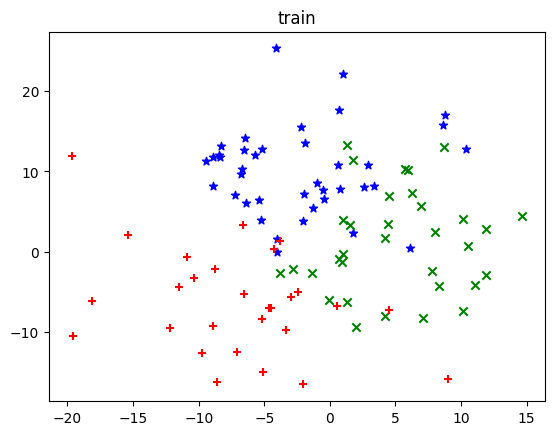

In [6]:
# Plotting the generated training dataset by class in a scatter plot
plt.figure()
y_unique = np.unique(y_train)
markers = "*x+"
colors = "bgr"
for i in range(len(y_unique)):
    plt.scatter(x_train[y_train == y_unique[i], 0], x_train[y_train == y_unique[i], 1], marker=markers[i], c=colors[i])
plt.title("train")

plt.show()

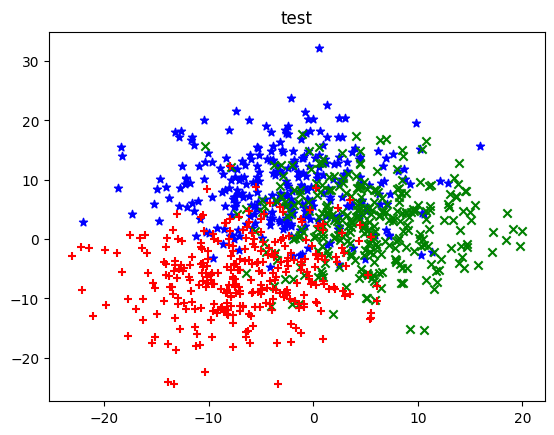

In [7]:
# Plotting the generated test dataset by class in a scatter plot
plt.figure()
for i in range(len(y_unique)):
    plt.scatter(x_test[y_test == y_unique[i], 0], x_test[y_test == y_unique[i], 1], marker=markers[i], c=colors[i])
plt.title("test")

plt.show()

Here is a quick way of computing the square distance between a $N\times D$ matrix $X1$ and a $T\times D$ matrix $X2$.

\begin{aligned}
X1 \odot X1 \mathbf{1}_{D,T} + \mathbf{1}_{N,D} X_2^\top \odot X_2^\top - 2X_1X_2^\top
\end{aligned}

where $\odot$ is element-wise multiplication.

In [74]:
import math
N, D, T = 4, 3, 5
X1 = np.array([[1,2,3],[2,3,4],[4,5,6], [2,3,4]]) # 4x3
X2 = np.array([[0.1, 0.2, 0.3], [0.3, 0.5, 0.4], [0.3, 0.6, 0.3], [0.5,0.7,0.4], [0.4,0.6,0.6]]) #5x3
I1 = np.ones((D,T))
I2 = np.ones((N,D))
a = (X1*X1)@I1
b = I2@(X2*X2).T
c = X1@X2.T
dist_square = a + b - 2*c
a, b, c, dist_square

for i in range(X1.shape[0]):
  for j in range(X2.shape[0]):
    print(((X1[i]-X2[j])**2).sum(), dist_square[i,j])
    # assert math.isclose(((X1[0]-X2[0])**2).sum(), dist_square[i,j], abs_tol=1e-3)

11.340000000000002 11.34
9.5 9.5
9.74 9.739999999999998
8.700000000000001 8.7
8.08 8.080000000000002
25.14 25.14
22.1 22.1
22.34 22.34
20.5 20.5
19.88 19.88
70.74000000000001 70.74
65.3 65.3
65.54 65.54
62.099999999999994 62.10000000000001
61.48000000000001 61.48
25.14 25.14
22.1 22.1
22.34 22.34
20.5 20.5
19.88 19.88


In [65]:
a = np.array([[4,3,1,5,2], [4,2,5,6,2]]).T
idx = np.argsort(a, 0)
y = np.array([1,2,3,4,5,6,7])
a, idx, y[idx]

y = np.array([[2,3,2,4,2,2,2], [3,4,4,4,4,4,1]], dtype=np.int32).T
unq, counts = np.unique(y[:,1], return_counts=True)
y[:,1], unq, counts, unq[np.argmax(counts)]

(array([3, 4, 4, 4, 4, 4, 1], dtype=int32),
 array([1, 3, 4], dtype=int32),
 array([1, 1, 5]),
 4)

In [92]:
def myKNN(X_train, y_train, X_test, k):
  N, D = X_train.shape
  T, _ = X_test.shape
  assert X_train.shape[1] == X_test.shape[1]
  a = (X_train*X_train)@np.ones((D, T))
  b = np.ones((N, D))@(X_test*X_test).T
  c = X_train@X_test.T
  dist_square = a + b - 2 * c # N,T

  idx = np.argsort(dist_square, 0)[:k] # get the top k closest neighbor idx.
  y_topk = y_train[idx]
  yhat = []
  # not very efficient but gets the job done.
  for i in range(T):
    unique, counts = np.unique(y_topk[:,i], return_counts=True)
    yhat.append(unique[np.argmax(counts)])
  return np.array(yhat)

In [95]:
y_pred = myKNN(x_train, y_train, x_test, 3)
y_pred

array([1, 2, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 0, 0, 1,
       2, 1, 2, 2, 0, 2, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 2, 2,
       2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 2, 1, 0, 0, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 1, 0, 1, 1, 2,
       0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0,
       1, 2, 2, 2, 0, 1, 2, 0, 2, 1, 2, 2, 1, 0, 2, 0, 0, 1, 2, 0, 0, 2,
       0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0, 1, 2, 1, 1, 2, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2,
       2, 0, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 2,
       2, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2, 1,
       1, 2, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 1, 1,
       2, 0, 2, 2, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 2, 1, 0, 0,
       1, 0, 1, 2, 1, 1, 2, 0, 1, 2, 2, 0, 0, 0, 0,

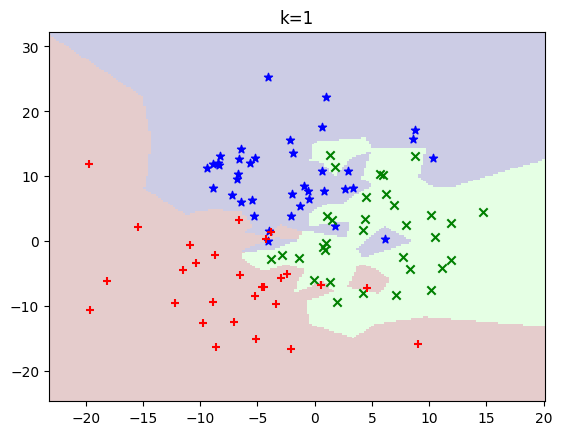

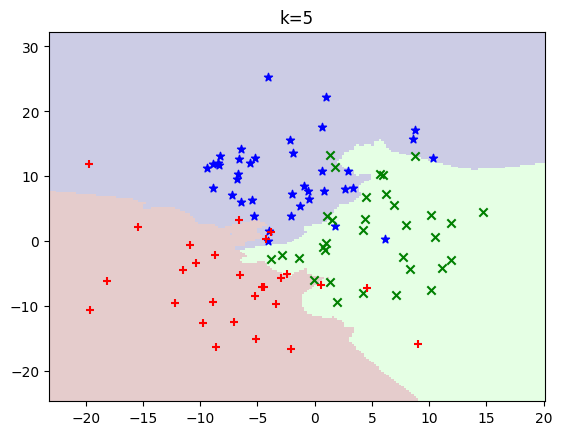

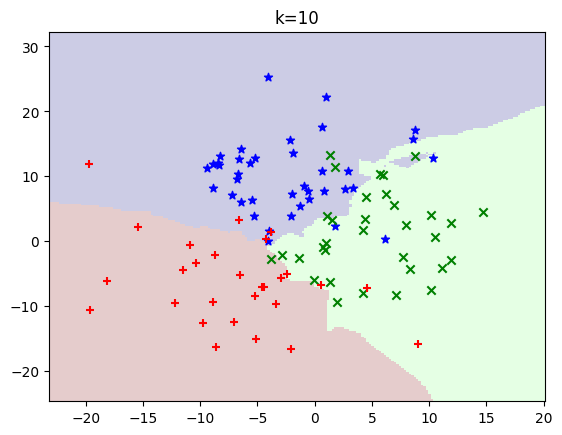

In [97]:
x = np.linspace(np.min(x_test[:, 0]), np.max(x_test[:, 0]), 200)
y = np.linspace(np.min(x_test[:, 1]), np.max(x_test[:, 1]), 200)
xx, yy = np.meshgrid(x, y)
xy = np.c_[xx.ravel(), yy.ravel()]

# Train a knn model and use the knn model to predict
use_my_knn = False
for k in [1, 5, 10]:
    if use_my_knn:
      y_predicted = myKNN(x_train, y_train, xy, k)
    else:
      knn = KNN(n_neighbors=k)
      knn.fit(x_train, y_train)
      y_predicted = knn.predict(xy)

    plt.figure()
    plt.pcolormesh(xx, yy, y_predicted.reshape(200, 200), cmap="jet", alpha=0.2)
    for i in range(len(y_unique)):
        plt.scatter(
            x_train[y_train == y_unique[i], 0], x_train[y_train == y_unique[i], 1], marker=markers[i], c=colors[i]
        )
    plt.title("k=%s" % (k))

    plt.show()

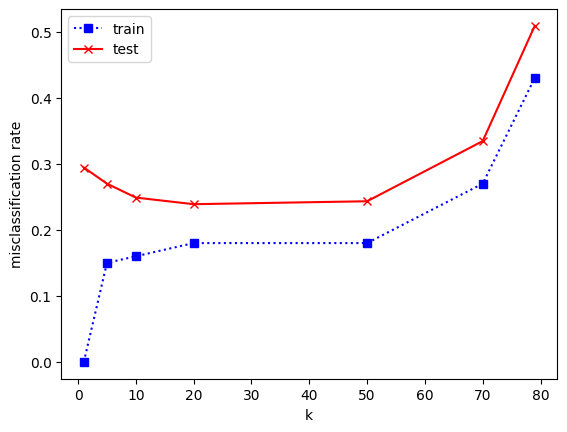

In [98]:
# plot train err and test err with different k
# ks = [int(n) for n in np.linspace(1, ntrain, 10)]
ks = [1, 5, 10, 20, 50, 70, 79]
train_errs = []
test_errs = []
for k in ks:
    knn = KNN(n_neighbors=k)
    knn.fit(x_train, y_train)
    train_errs.append(1 - knn.score(x_train, y_train))
    test_errs.append(1 - knn.score(x_test, y_test))
plt.figure()
plt.plot(ks, train_errs, "bs:", label="train")
plt.plot(ks, test_errs, "rx-", label="test")
plt.legend()
plt.xlabel("k")
plt.ylabel("misclassification rate")

plt.show()

Text(0.5, 1.0, '5-fold cross validation, n-train = 200')

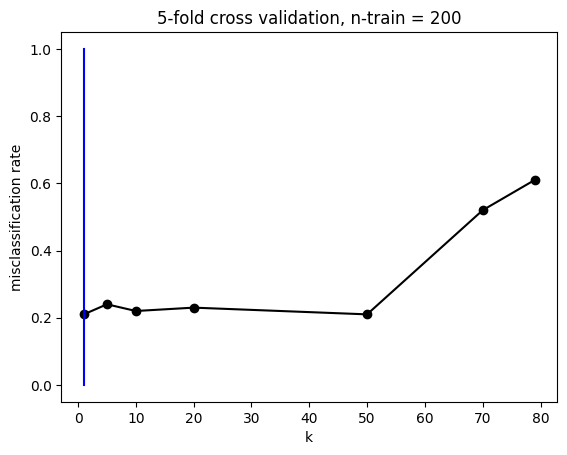

In [99]:
# cross_validate
scores = []
for k in ks:
    knn = KNN(n_neighbors=k)
    score = cross_val_score(knn, x_train, y_train, cv=5)
    scores.append(1 - score.mean())
plt.figure()
plt.plot(ks, scores, "ko-")
min_k = ks[np.argmin(scores)]
plt.plot([min_k, min_k], [0, 1.0], "b-")
plt.xlabel("k")
plt.ylabel("misclassification rate")
plt.title("5-fold cross validation, n-train = 200")

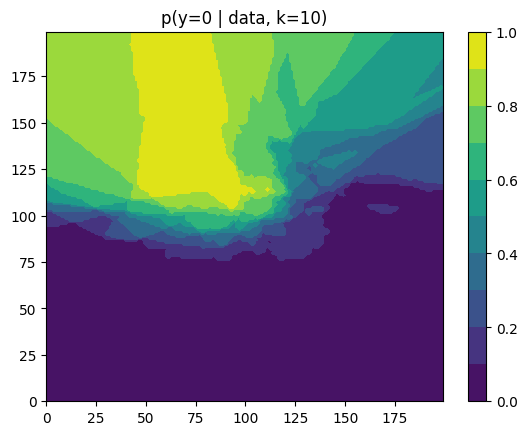

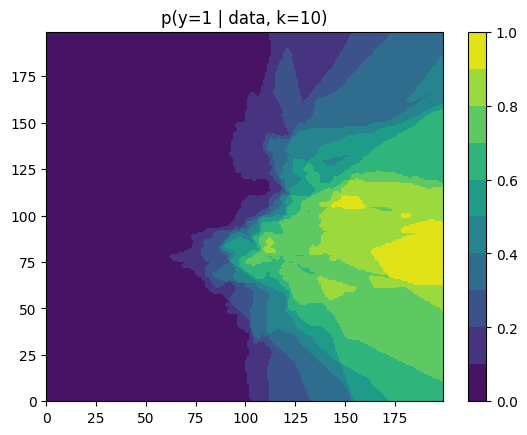

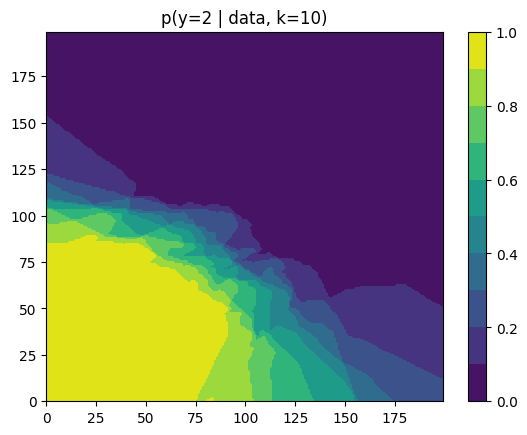

In [100]:
# draw hot-map to show the probability of different class
knn = KNN(n_neighbors=10)
knn.fit(x_train, y_train)
xy_predic = knn.predict_proba(xy)
levels = np.arange(0, 1.01, 0.1)
for i in range(3):
    plt.figure()
    plt.contourf(xy_predic[:, i].ravel().reshape(200, 200), levels)
    plt.colorbar()
    plt.title("p(y=%s | data, k=10)" % (i))
plt.show()